In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# Read the dataset from the file
data = pd.read_csv('car+evaluation/car.data', header=None)

# Display the first few rows of the dataset
print(data.head())
data.info()
unique_values = data[6].unique()
data[6] = data[6].replace({'unacc': -1, 'acc': 1, 'good': 1, 'vgood': 1})
data[6].unique()

       0      1  2  3      4     5      6
0  vhigh  vhigh  2  2  small   low  unacc
1  vhigh  vhigh  2  2  small   med  unacc
2  vhigh  vhigh  2  2  small  high  unacc
3  vhigh  vhigh  2  2    med   low  unacc
4  vhigh  vhigh  2  2    med   med  unacc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1728 non-null   object
 1   1       1728 non-null   object
 2   2       1728 non-null   object
 3   3       1728 non-null   object
 4   4       1728 non-null   object
 5   5       1728 non-null   object
 6   6       1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


array([-1,  1], dtype=int64)

In [54]:
#convert all columns to numeric
for i in range(0, 6):
    data[i] = pd.Categorical(data[i])
    data[i] = data[i].cat.codes

data[6].unique()

array([-1,  1], dtype=int64)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

columns = [0,1,2,3,4,5]

train_X, test_X, train_y, test_y = train_test_split(data[columns], data[6], test_size=0.3)

# Create an instance of the StandardScaler
scaler = MinMaxScaler()

# Normalize the data
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X

array([[1.        , 0.66666667, 0.66666667, 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.5       , 1.        ,
        0.        ],
       [0.66666667, 0.66666667, 0.33333333, 0.        , 0.5       ,
        1.        ],
       ...,
       [0.        , 0.        , 1.        , 0.        , 1.        ,
        0.5       ],
       [0.66666667, 0.        , 0.33333333, 1.        , 0.5       ,
        0.        ],
       [0.33333333, 0.33333333, 1.        , 0.        , 1.        ,
        0.5       ]])

In [81]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))
def linear_kernel(x, y):
    return np.dot(x, y)
kernel_matrix = np.array([[gaussian_kernel(x, y) for y in train_X] for x in train_X])
kernel_matrix


array([[1.        , 0.40544187, 0.47897297, ..., 0.24591292, 0.38353157,
        0.38353157],
       [0.40544187, 1.        , 0.39984965, ..., 0.17377394, 0.42269216,
        0.30287217],
       [0.47897297, 0.39984965, 1.        , ..., 0.39984965, 0.29457483,
        0.55803515],
       ...,
       [0.24591292, 0.17377394, 0.39984965, ..., 1.        , 0.30287217,
        0.89483932],
       [0.38353157, 0.42269216, 0.29457483, ..., 0.30287217, 1.        ,
        0.33846543],
       [0.38353157, 0.30287217, 0.55803515, ..., 0.89483932, 0.33846543,
        1.        ]])

In [59]:
np.outer(train_y, train_y)

array([[ 1,  1,  1, ...,  1, -1,  1],
       [ 1,  1,  1, ...,  1, -1,  1],
       [ 1,  1,  1, ...,  1, -1,  1],
       ...,
       [ 1,  1,  1, ...,  1, -1,  1],
       [-1, -1, -1, ..., -1,  1, -1],
       [ 1,  1,  1, ...,  1, -1,  1]], dtype=int64)

In [70]:
outer_y * kernel_matrix

array([[ 1.88888889,  1.66666667,  1.33333333, ...,  0.66666667,
        -0.88888889,  1.22222222],
       [ 1.66666667,  3.25      ,  1.83333333, ...,  1.        ,
        -1.66666667,  1.66666667],
       [ 1.33333333,  1.83333333,  2.25      , ...,  1.33333333,
        -0.80555556,  1.77777778],
       ...,
       [ 0.66666667,  1.        ,  1.33333333, ...,  2.25      ,
        -0.83333333,  2.25      ],
       [-0.88888889, -1.66666667, -0.80555556, ..., -0.83333333,
         1.80555556, -1.05555556],
       [ 1.22222222,  1.66666667,  1.77777778, ...,  2.25      ,
        -1.05555556,  2.47222222]])

In [83]:
alpha = cp.Variable((train_X.shape[0],1))
outer_y = train_y.values.reshape((-1,1)) * train_y.values.reshape((-1,1)).T
gram = outer_y * kernel_matrix
objective = cp.Minimize(-cp.sum(alpha) + 0.5 * cp.quad_form(alpha, cp.psd_wrap(gram)))
constraints = [0 <= alpha, alpha <= 1, train_y.values @ alpha == 0]

problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.SCS)
print("problem status: ",problem.status)

problem status:  optimal


In [97]:
# support_vector_indices = np.where(alpha.value > 1e-5)[0]
# support_vectors = train_X[support_vector_indices]
# support_vector_labels = train_y.values[support_vector_indices]

test_kernel_matrix = np.array([[gaussian_kernel(x, y) for y in test_X] for x in train_X])
predictions = np.sign(np.sum(train_y.values.reshape((-1,1)) * alpha.value * test_kernel_matrix, axis=0))

accuracy = np.mean(predictions == test_y.values)
print(f"Accuracy: {accuracy}")

Accuracy: 0.789980732177264


In [ ]:
training_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(training_data.index)
# Extract the features and labels from the dataset
X = training_data.iloc[:, :-1].values
y = training_data.iloc[:, -1].values.reshape(X.shape[0], 1)

# Define the SVM variables
w = cp.Variable((X.shape[1],1))
b = cp.Variable()
n = cp.Variable((X.shape[0],1))
const = np.ones((X.shape[0],1))

# Define the SVM constraints
constraints = [cp.multiply(y, (X @ w + b)) >= const - n, n >= 0]

# Define the objective function to minimize the sum of the regularization term
objective = cp.Minimize(cp.norm2(w) + cp.norm1(n))

# Define the SVM problem
problem = cp.Problem(objective, constraints)

# Solve the SVM problem
problem.solve()

# Print the accuracy
accuracy = np.mean(np.sign(X @ w.value + b.value) == y)
print(accuracy)


ValueError: x and y must be the same size

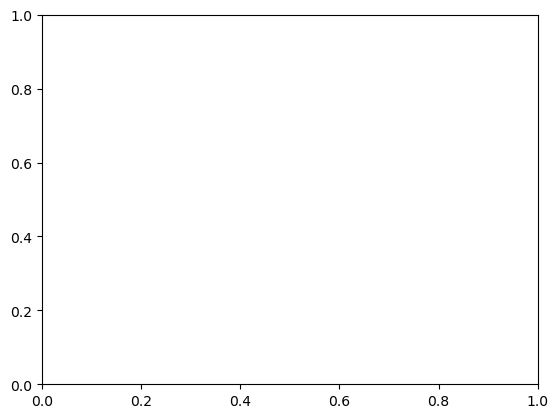

In [53]:
# Plot the scatter points
plt.scatter(X[:, 1:6], X[:, 0], c=y)
plt.xlabel('Features 1-5')
plt.ylabel('Feature 0')
plt.title('SVM Model')
plt.show()


Hi! We plan to train four separate Support Vector Machine (SVM) models with a unique approach.

There's four possible values in the target value: A B C D. 

First Model (Binary Classification for A): In the first model, category A will be labeled as '1', while B, C, and D will be labeled as '-1'. This model's primary objective is to differentiate category A from the others.

Next Three Models (One-vs-One Approach): For the subsequent three models, we will employ a one-vs-one strategy where each model will differentiate A from one of the other categories (B, C, or D). Specifically, the models will be: A=1, B=-1; A=1, C=-1; and A=1, D=-1.

Accuracy Evaluation in Three Phases:

First Phase: we will evaluate the accuracy of the first model (A vs. BCD) independently.

Second Phase: The second evaluation will involve the combined accuracy of the next three models. The prediction for each instance will be the majority vote from these models. If the majority vote is inconclusive, we'll randomly select between the two equally probable classes.

Third Phase: The final accuracy evaluation will combine all four models. The prediction will again be based on the majority vote. In cases where there is a tie (two '1's and two '-1's), we will randomly select between '-1' and '1' for the final prediction.

Do you find this approach feasible and valid for evaluating the performance of SVM models in a multi-class classification problem?
